In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# ignore all warnings as sometimes these models throw random warnings
import warnings
warnings.warn = lambda *a, **kw: False

In [3]:
KFOLDER = "/Users/megandass/Documents/cs229b/cs229b_proj/"

In [4]:
df = pd.read_csv(os.path.join(KFOLDER, "datasets/bitcoin.csv"))
df['timestamp'] = pd.to_datetime(df['timestamp']) # convert the timestamp strings into datetimes
df.tail()

,timestamp,prices,market_caps,total_volumes
3823,2023-10-18 00:00:00,28417.721752,5.550031e+11,1.040325e+10
3824,2023-10-19 00:00:00,28328.245198,5.533111e+11,1.346103e+10
3825,2023-10-20 00:00:00,28715.748142,5.593640e+11,1.119392e+10
3826,2023-10-21 00:00:00,29677.392888,5.795368e+11,2.356141e+10
3827,2023-10-21 17:11:21,29900.050788,5.835680e+11,1.121431e+10


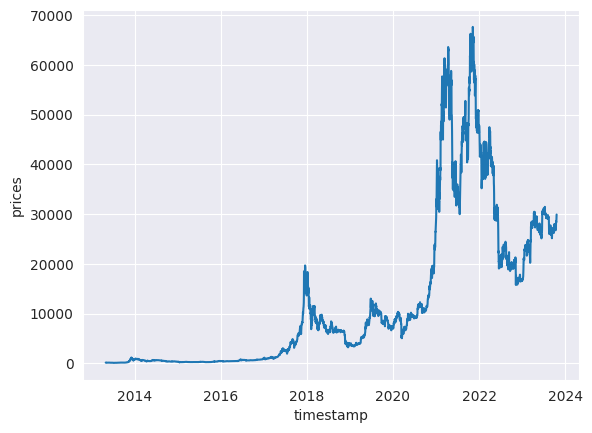

In [5]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=df['timestamp'], y=df['prices'])

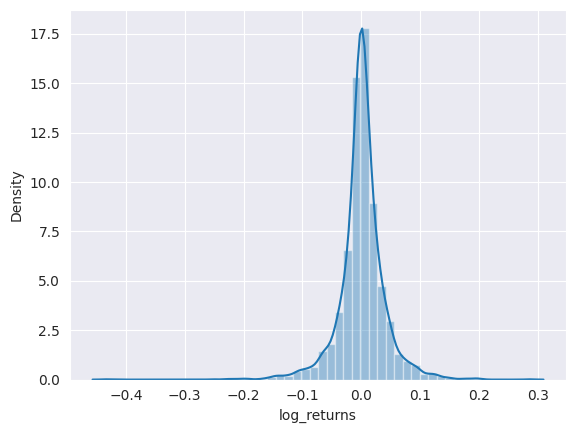

In [6]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['log_returns'], 100)
returns = pd.DataFrame(df['log_returns'].dropna())
with sns.axes_style("darkgrid"):
    sns.distplot(returns['log_returns'])

In [7]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [8]:
realized_volatility_daily(df["log_returns"])

0.039800176515436325

In [9]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [10]:
df.dropna(inplace=True) # drop NaN values produced by shifts

# Train test split

In [11]:
from torch.autograd import Variable
import torch

In [12]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train_idx, test_idx = df.index[:train_size], df.index[train_size:]

ts_train, ts_test = df.timestamp[:train_size], df.timestamp[train_size:]
X_train, X_test, y_train, y_test = df.vol_current[:train_size], df.vol_current[train_size:], df.vol_future[:train_size], df.vol_future[train_size:]

X_train.head()

30    0.067346
31    0.066884
32    0.066631
33    0.060927
34    0.056486
Name: vol_current, dtype: float64

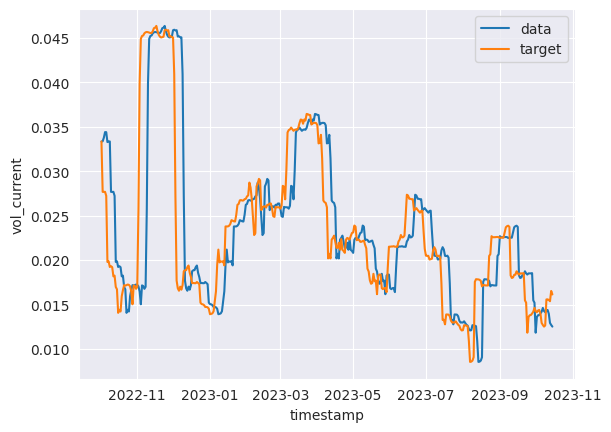

In [13]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=ts_test, y=X_test, label="data")
    sns.lineplot(x=ts_test, y=y_test, label="target")

# Forecast

In [14]:
forecasts = []
for i in range(test_size):
    idx = test_idx[i]
    model = arch_model(df.log_returns[:train_size + i], p=1, q=1, o=1, power=1.0, dist="skewt")
    model_fit = model.fit(disp='off')
    
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values

    pred = np.sqrt(np.mean(vaR))
    forecasts.append(pred)

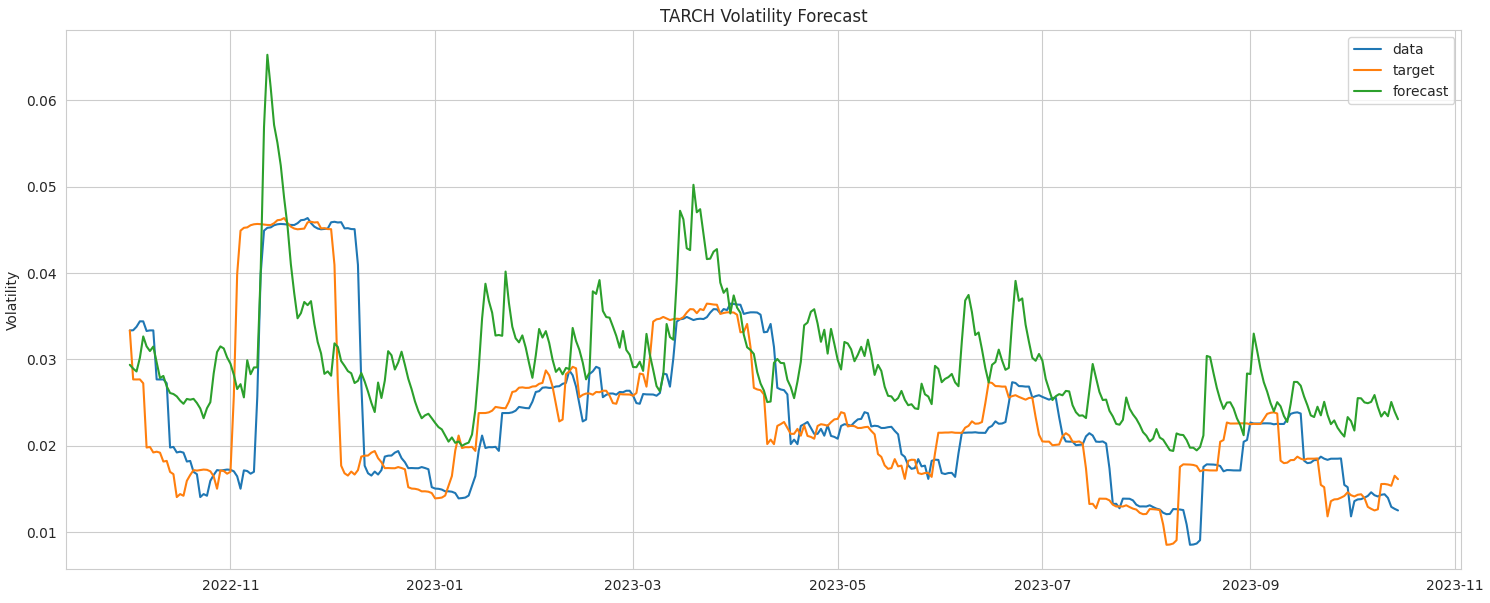

In [15]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.lineplot(x=ts_test, y=X_test, label="data")
    sns.lineplot(x=ts_test, y=y_test, label="target")
    sns.lineplot(x=ts_test, y=forecasts, label="forecast")
    ax.set(xlabel='', 
           ylabel='Volatility', 
           title='TARCH Volatility Forecast')
    plt.savefig(os.path.join(KFOLDER, "TARCH_vol.png"), dpi=300, bbox_inches='tight')

# Evaluate

In [16]:
model = arch_model(df['log_returns'], p=1, q=1, o=1, power=1.0, dist="skewt")
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - TARCH/ZARCH Model Results                        
=========================================================================================
Dep. Variable:                       log_returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:                7777.14
Distribution:      Standardized Skew Student's t   AIC:                          -15540.3
Method:                       Maximum Likelihood   BIC:                          -15496.6
                                                   No. Observations:                 3790
Date:                           Mon, Dec 11 2023   Df Residuals:                     3789
Time:                                   01:10:51   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.5702e-04  4.468e-04      1.694  9.023e-02 [-1.188e-04,1.633e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.6028e-03  1.864e-03      0.860      0.390 [-2.051e-03,5.257e-03]
alpha[1]       0.1436  3.379e-02      4.250  2.136e-05    [7.738e-02,  0.210]
gamma[1]      -0.0109  2.203e-02     -0.493      0.622 [-5.403e-02,3.231e-02]
beta[1]        0.8618  8.315e-02     10.365  3.590e-25      [  0.699,  1.025]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
eta            3.1969      0.170     18.797  7.949e-79      [  2.864,  3.530]
lambda        -0.0288  1.800e-02     -1.601      0.109 [-6.408e-02,6.467e-03]
=============================================================================

Covariance estimator: robust
"""

In [17]:
def RMSE(y_true, y_pred):
    output = np.sqrt(mean_squared_error(y_true, y_pred))
    return output

In [18]:
RMSE(y_test, forecasts)

0.008751802275842734